In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Stratified Difference in Distributions of First- and Second-Best Matches

## Data

In [2]:
first_match = pd.read_csv('/Users/joshuaingram/Main/Projects/starsml/data/new/most_probable_new.csv')
second_match= pd.read_csv('/Users/joshuaingram/Main/Projects/starsml/data/new/second_new.csv')

## Sample Size by Max Separation

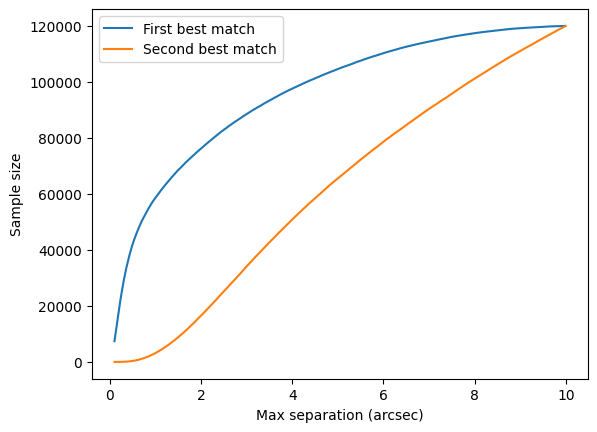

In [3]:
# First best match sample size by max separation
max_sep = np.arange(0.1, 10, 0.01)
first_match_sample_size = []
for sep in max_sep:
    first_match_sample_size.append(len(first_match[first_match['dist_arcsec'] < sep]))

# Second best match sample size by max separation
second_match_sample_size = []
for sep in max_sep:
    second_match_sample_size.append(len(second_match[second_match['dist_arcsec'] < sep]))

# Plot
plt.plot(max_sep, first_match_sample_size, label='First best match')
plt.plot(max_sep, second_match_sample_size, label='Second best match')
plt.xlabel('Max separation (arcsec)')
plt.ylabel('Sample size')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_max_separation.png')
plt.show()

## Function

In [4]:
def ks_test_filter_ranges(data1, data2, variable, filter_column1, filter_column2, 
                          filter1, filter2, filter3, filter4,
                          filter_count = "first", unique_id = "chandra_source_id"):
    """
    This function takes in two dataframes and performs a KS test on the variable
    specified. The KS test is performed on the variable for the dataframes
    filtered by the specified filters. The function returns a dataframe with the
    KS test results for each filter.
    """

    if filter_count == "first":
        data1 = data1[(data1[filter_column1] > filter1) & (data1[filter_column1] <= filter2) & (data1[filter_column2] > filter3) & (data1[filter_column2] <= filter4)]
        data2 = data2[data2[unique_id].isin(data1[unique_id])]
    elif filter_count == "second":
        data2 = data2[data2[filter_column1] > filter1 & data2[filter_column1] < filter2 & data2[filter_column2] > filter3 & data2[filter_column2] < filter4]
        data1 = data1[data1[unique_id].isin(data2[unique_id])]
    elif filter_count == "both":
        data1 = data1[data1[filter_column1] > filter1 & data1[filter_column1] < filter2 & data1[filter_column2] > filter3 & data1[filter_column2] < filter4]
        data2 = data2[data2[filter_column1] > filter1 & data2[filter_column1] < filter2 & data2[filter_column2] > filter3 & data2[filter_column2] < filter4]
    else:
        print("Invalid filter_count. Please enter 'first', 'second', or 'both'.")

    if len(data1) == 0 or len(data2) == 0:
        # print("No data found for the specified filters.")
        return [None, None, 0, 0]
    
    sample1 = data1[variable]
    sample2 = data2[variable]

    ks_test_results = stats.ks_2samp(sample1, sample2)

    return [ks_test_results.statistic, ks_test_results.pvalue, len(data1), len(data2)]


In [5]:
# Function to create bins with at least `min_count` values in each
def create_bins_with_min_count(dataframe, column, min_count=1000):
    sorted_values = dataframe[column].sort_values().values
    bins = []
    current_count = 0

    # Iterate through sorted values and create bins
    for value in sorted_values:
        current_count += 1
        if current_count >= min_count:
            bins.append(value)
            current_count = 0

    # Ensure the last bin captures the max value
    if bins[-1] != sorted_values[-1]:
        bins.append(sorted_values[-1])

    # Adding the minimum value (0) to the start of the bins
    bins.insert(0, 0)

    return bins

## Results

In [6]:
# remove na rows for gmean column
bin_edges = create_bins_with_min_count(first_match[first_match['phot_g_mean_mag'].notna()], 'dist_arcsec', min_count=1000)
print(bin_edges)
bin_edges = create_bins_with_min_count(first_match, 'dist_arcsec', min_count=1000)
print(bin_edges)

# about 500 missing values
print(len(first_match[first_match['phot_g_mean_mag'].notna()]))
print(len(first_match))

# missing about 25,000 values
print(len(first_match[first_match['min_theta_mean'].notna()]))

[0, 0.0259396639991144, 0.0424922977974709, 0.0552562124728267, 0.0666721257036816, 0.0771706240250589, 0.0870562478179826, 0.0967922875997675, 0.106032666701278, 0.1149418065868018, 0.1237924978754703, 0.1327082149524089, 0.1416209378467427, 0.1506616307646296, 0.1593780412350184, 0.1685892167530299, 0.1775740894836383, 0.1860409422292667, 0.1944006897405498, 0.2028380253933346, 0.2116796297344954, 0.2213106231307647, 0.23038109597125, 0.2407465221408365, 0.2513099332946367, 0.2616426131802118, 0.2721989789282414, 0.2824800100003012, 0.2936891292683015, 0.305245662503697, 0.3165264621244543, 0.3288026796360324, 0.3415521659585321, 0.3544832982579354, 0.3689213631779859, 0.3834598295329486, 0.3983169630215558, 0.4138740396850079, 0.4301590435470926, 0.4468982727326391, 0.4638991477255819, 0.4818003218000861, 0.5018878262561737, 0.5219594408121311, 0.5442966538604023, 0.5675441424639041, 0.5912863191399039, 0.6162820257378281, 0.6426871763891862, 0.6685281389378492, 0.6968355662312353, 

### GMean

In [7]:
# phot_g_mean_mag
variable = 'phot_g_mean_mag'
filter_column1 = 'dist_arcsec'
filter_column2 = "min_theta_mean"
filter_count = "first"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle) <- be careful, this seems to be removing some of the data
filter3 = [0, 3, 5]
filter4 = [3, 5, 10]

# KS test results
ks_test_results_stat = []
ks_test_results_pvalue = []
min_sep = []
max_sep = []
med_sep = []
min_offaxis = []
max_offaxis = []
filter_by = []
n_first = []
n_second = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     filter_count = filter_count)
        
        ks_test_results_stat.append(ks_test_results[0])
        ks_test_results_pvalue.append(ks_test_results[1])
        min_sep.append(filter1[i])
        max_sep.append(filter2[i])
        med_sep.append((filter1[i] + filter2[i])/2)
        min_offaxis.append(filter3[j])
        max_offaxis.append(filter4[j])
        filter_by.append(filter_count)
        n_first.append(ks_test_results[2])
        n_second.append(ks_test_results[3])

ks_test_results_df = pd.DataFrame({'statistic': ks_test_results_stat, 'pvalue': ks_test_results_pvalue, 
                                   'min_sep': min_sep, 'max_sep': max_sep, 'med_sep': med_sep,
                                   'min_offaxis': min_offaxis, 'max_offaxis': max_offaxis, 
                                   'filter_by': filter_by, 'n_first': n_first, 'n_second': n_second})


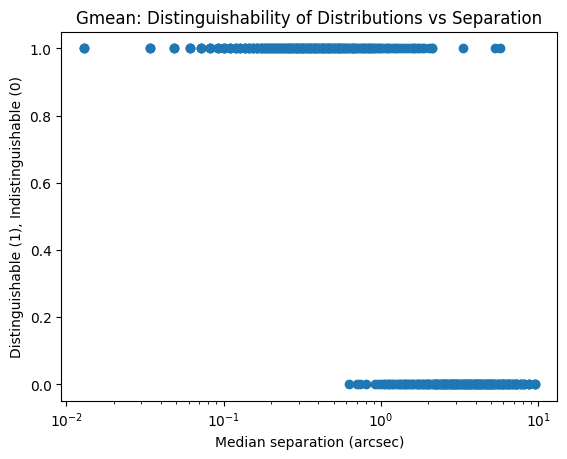

In [16]:
# make p-values binary (0.05)
ks_test_results_df['pvalue_binary'] = ks_test_results_df['pvalue'].apply(lambda x: 1 if x < 0.05 else 0)

# plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0)')
plt.title('Gmean: Distinguishability of Distributions vs Separation')
plt.xscale('log')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/binary_pvalue_vs_median_separation_aggregate_gmean.png')
plt.show()


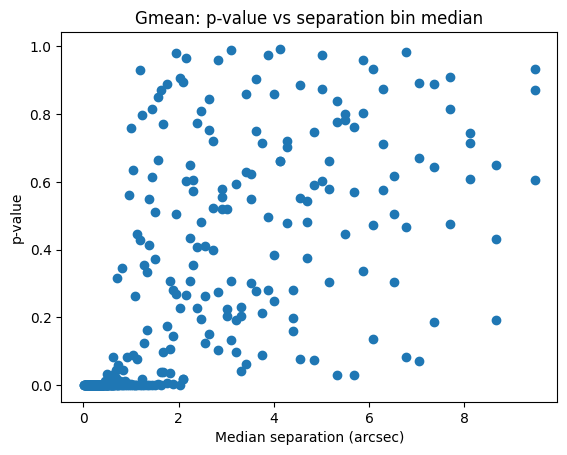

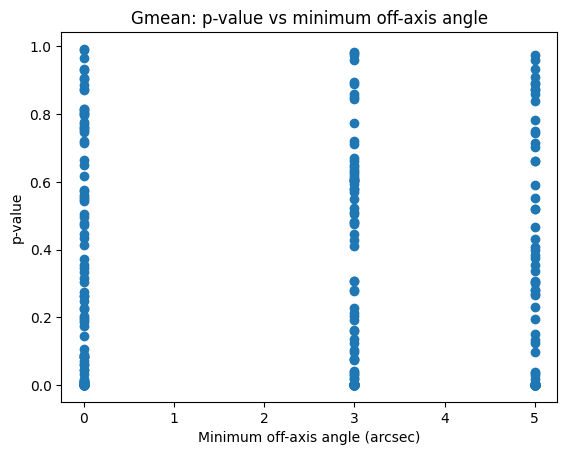

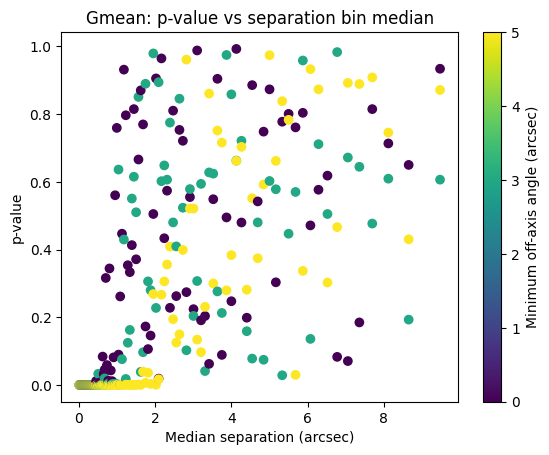

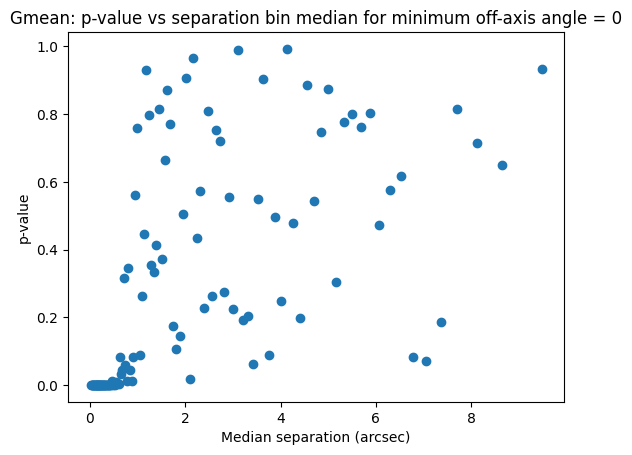

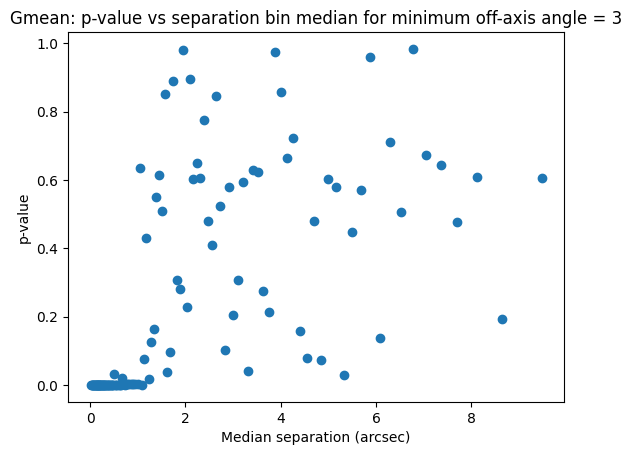

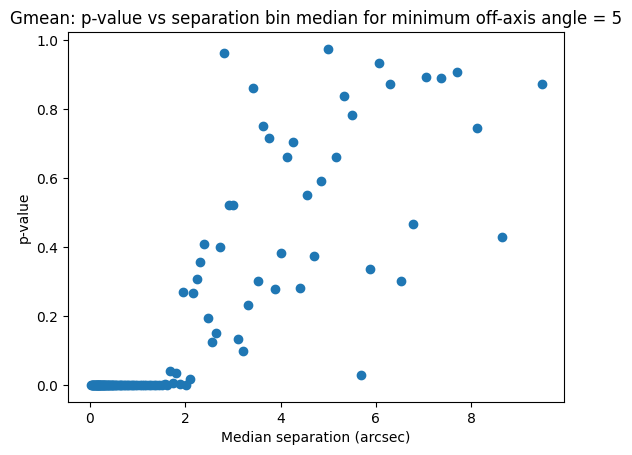

In [8]:
# Plot p-values vs separation with title
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('Gmean: p-value vs separation bin median')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_aggregate_gmean.png')
plt.show()

# Plot p-values vs off-axis angle with title
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('Gmean: p-value vs minimum off-axis angle')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_minimum_offaxis_aggregate_gmean.png')
plt.show()

# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('Gmean: p-value vs separation bin median')
plt.colorbar(label='Minimum off-axis angle (arcsec)')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_color_offaxis_aggregate_gmean.png')
plt.show()

# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('Gmean: p-value vs separation bin median for minimum off-axis angle = ' + str(i))
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_gmean.png')
    plt.show()



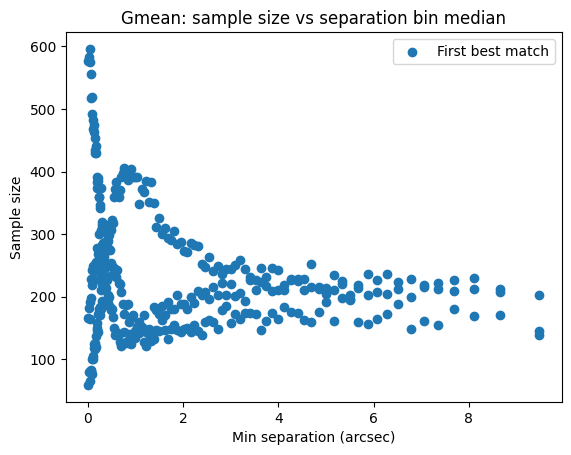

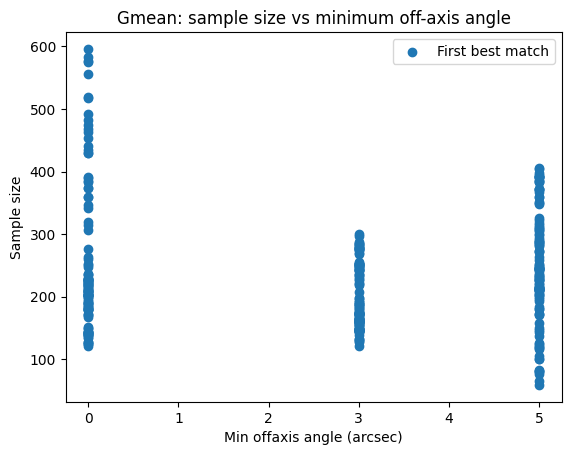

In [149]:
# plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('Gmean: sample size vs separation bin median')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_separation_gmean.png')
plt.show()

# plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('Gmean: sample size vs minimum off-axis angle')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_offaxis_gmean.png')
plt.show()

### BPMean

In [150]:
# phot_bp_mean_mag
variable = 'phot_bp_mean_mag'
filter_column1 = 'dist_arcsec'
filter_column2 = "min_theta_mean"
filter_count = "first"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle) <- be careful, this seems to be removing some of the data
filter3 = [0, 3, 5]
filter4 = [3, 5, 10]

# KS test results
ks_test_results_stat = []
ks_test_results_pvalue = []
min_sep = []
max_sep = []
med_sep = []
min_offaxis = []
max_offaxis = []
filter_by = []
n_first = []
n_second = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     filter_count = filter_count)
        ks_test_results_stat.append(ks_test_results[0])
        ks_test_results_pvalue.append(ks_test_results[1])
        min_sep.append(filter1[i])
        max_sep.append(filter2[i])
        med_sep.append((filter1[i] + filter2[i])/2)
        min_offaxis.append(filter3[j])
        max_offaxis.append(filter4[j])
        filter_by.append(filter_count)
        n_first.append(ks_test_results[2])
        n_second.append(ks_test_results[3])

ks_test_results_df = pd.DataFrame({'statistic': ks_test_results_stat, 'pvalue': ks_test_results_pvalue, 
                                   'min_sep': min_sep, 'max_sep': max_sep, 'med_sep': med_sep,
                                   'min_offaxis': min_offaxis, 'max_offaxis': max_offaxis, 
                                   'filter_by': filter_by, 'n_first': n_first, 'n_second': n_second})

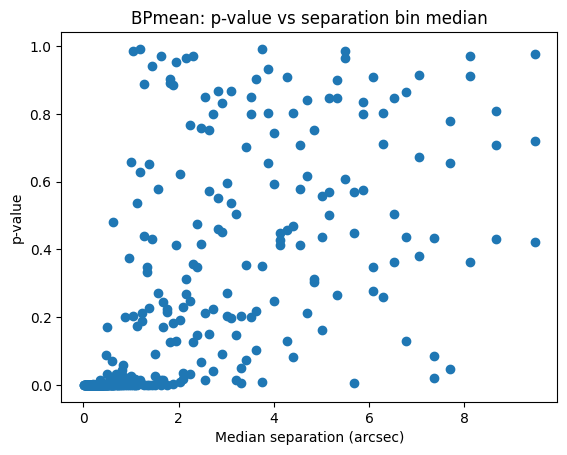

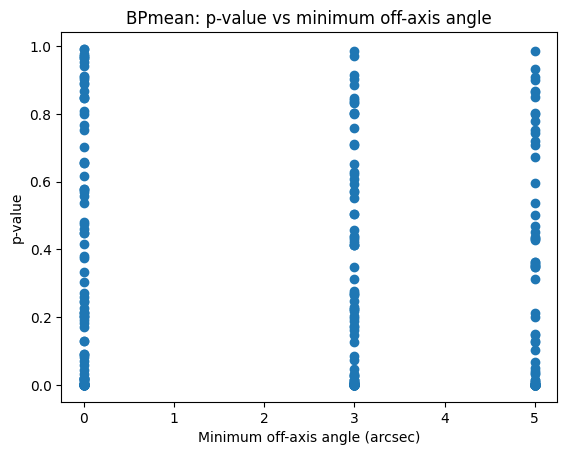

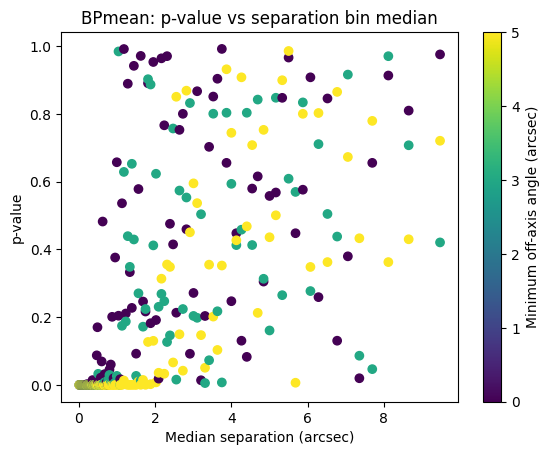

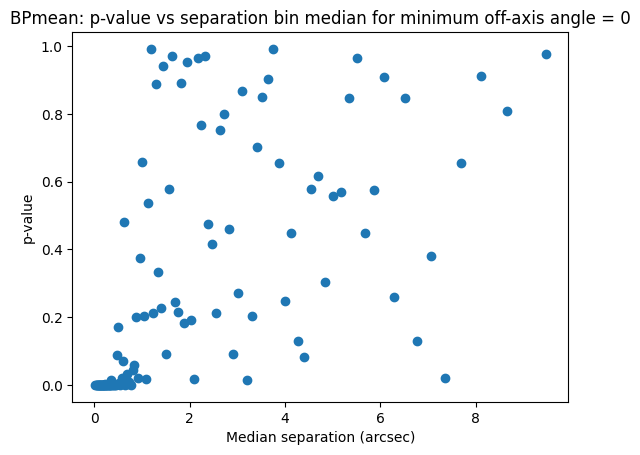

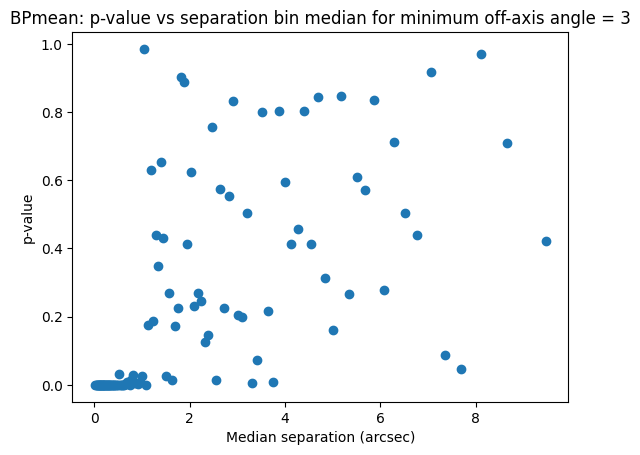

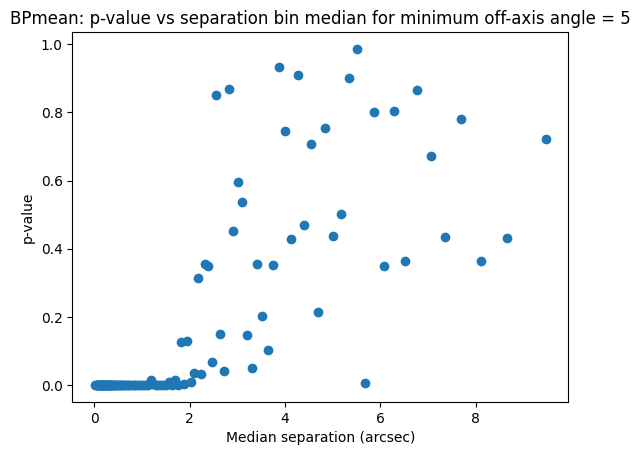

In [151]:
# Plot p-values vs separation with title
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BPmean: p-value vs separation bin median')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_aggregate_bpmean.png')
plt.show()

# Plot p-values vs off-axis angle with title
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('BPmean: p-value vs minimum off-axis angle')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_minimum_offaxis_aggregate_bpmean.png')
plt.show()

# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BPmean: p-value vs separation bin median')
plt.colorbar(label='Minimum off-axis angle (arcsec)')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_color_offaxis_aggregate_bpmean.png')
plt.show()

# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('BPmean: p-value vs separation bin median for minimum off-axis angle = ' + str(i))
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_bpmean.png')
    plt.show()

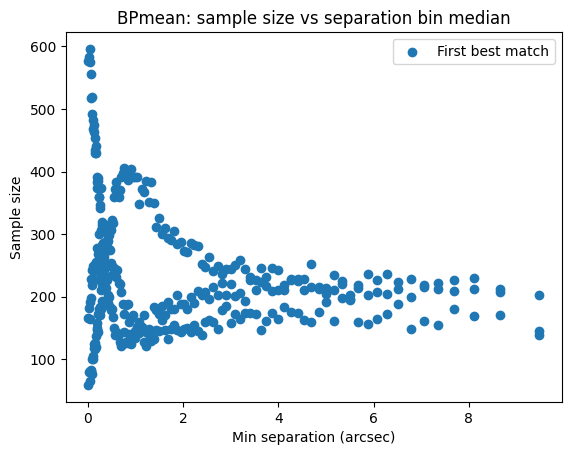

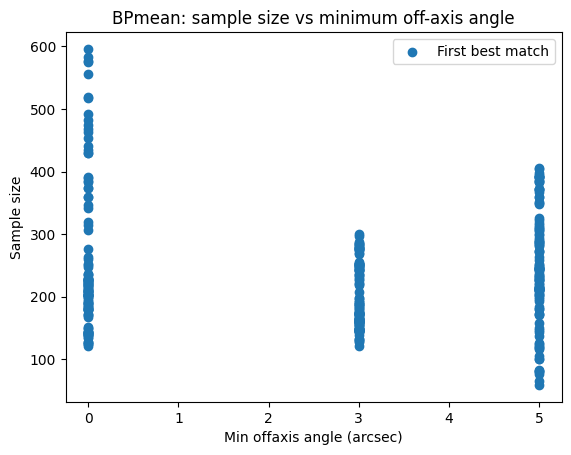

In [152]:
# plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('BPmean: sample size vs separation bin median')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_separation_bpmean.png')
plt.show()

# plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('BPmean: sample size vs minimum off-axis angle')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_offaxis_bpmean.png')
plt.show()

### RPMean

In [153]:
# phot_rp_mean_mag
variable = 'phot_rp_mean_mag'
filter_column1 = 'dist_arcsec'
filter_column2 = "min_theta_mean"
filter_count = "first"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle) <- be careful, this seems to be removing some of the data
filter3 = [0, 3, 5]
filter4 = [3, 5, 10]

# KS test results
ks_test_results_stat = []
ks_test_results_pvalue = []
min_sep = []
max_sep = []
med_sep = []
min_offaxis = []
max_offaxis = []
filter_by = []
n_first = []
n_second = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     filter_count = filter_count)
        ks_test_results_stat.append(ks_test_results[0])
        ks_test_results_pvalue.append(ks_test_results[1])
        min_sep.append(filter1[i])
        max_sep.append(filter2[i])
        med_sep.append((filter1[i] + filter2[i])/2)
        min_offaxis.append(filter3[j])
        max_offaxis.append(filter4[j])
        filter_by.append(filter_count)
        n_first.append(ks_test_results[2])
        n_second.append(ks_test_results[3])

ks_test_results_df = pd.DataFrame({'statistic': ks_test_results_stat, 'pvalue': ks_test_results_pvalue, 
                                   'min_sep': min_sep, 'max_sep': max_sep, 'med_sep': med_sep,
                                   'min_offaxis': min_offaxis, 'max_offaxis': max_offaxis, 
                                   'filter_by': filter_by, 'n_first': n_first, 'n_second': n_second})

In [160]:
# find separation bin where p-value is 0.05
ks_test_results_df[ks_test_results_df['pvalue'] > 0.05].max_sep

165    0.891869
171    0.973674
174    1.018676
177    1.063879
178    1.063879
         ...   
355    8.951957
356    8.951957
357    9.998549
358    9.998549
359    9.998549
Name: max_sep, Length: 160, dtype: float64

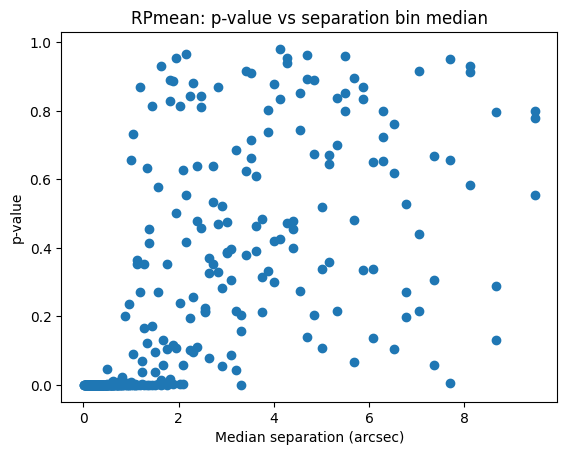

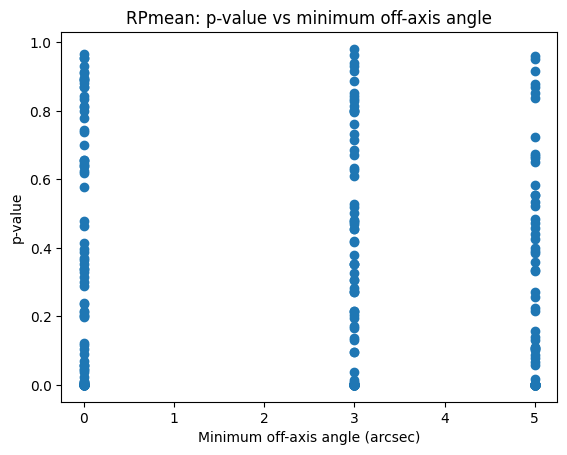

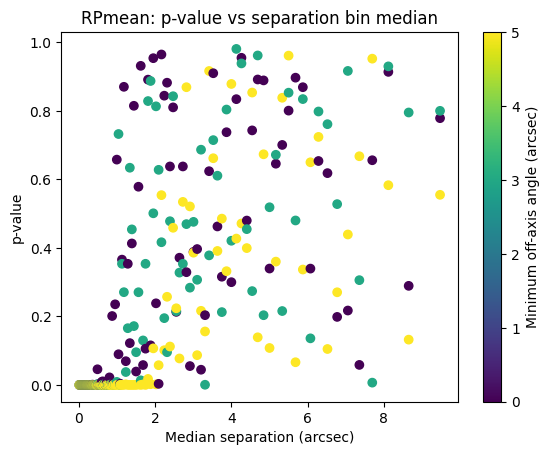

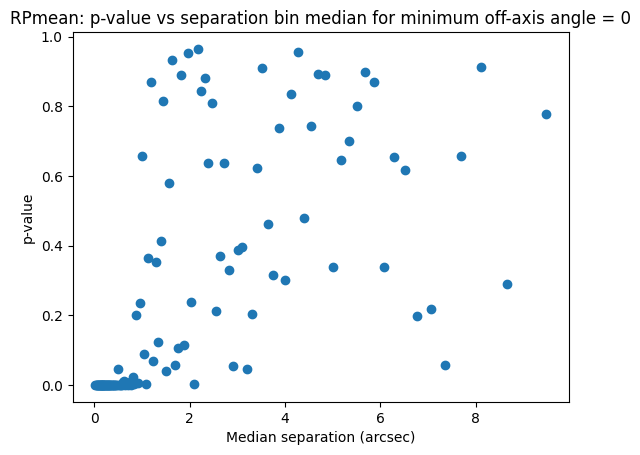

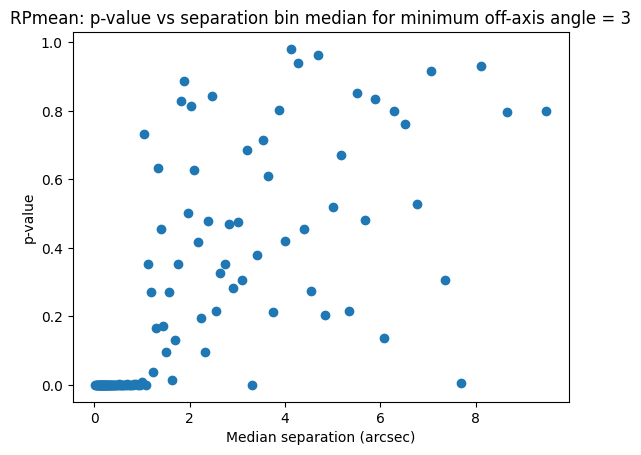

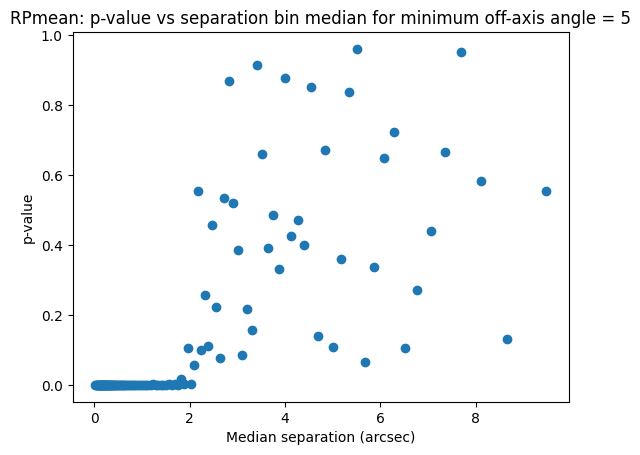

In [154]:
# Plot p-values vs separation with title
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RPmean: p-value vs separation bin median')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_aggregate_rpmean.png')
plt.show()

# Plot p-values vs off-axis angle with title
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('RPmean: p-value vs minimum off-axis angle')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_minimum_offaxis_aggregate_rpmean.png')
plt.show()

# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RPmean: p-value vs separation bin median')
plt.colorbar(label='Minimum off-axis angle (arcsec)')
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_color_offaxis_aggregate_rpmean.png')
plt.show()

# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('RPmean: p-value vs separation bin median for minimum off-axis angle = ' + str(i))
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_rpmean.png')
    plt.show()

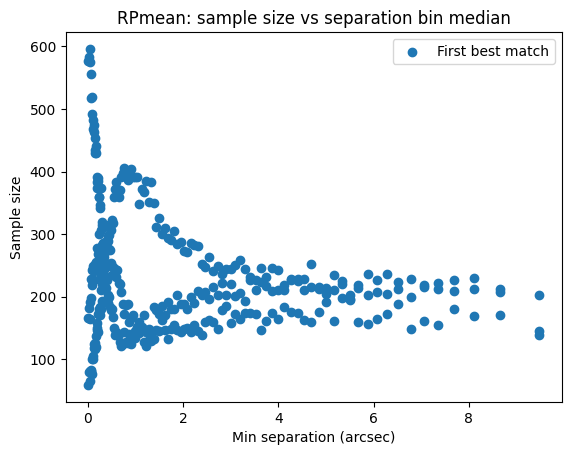

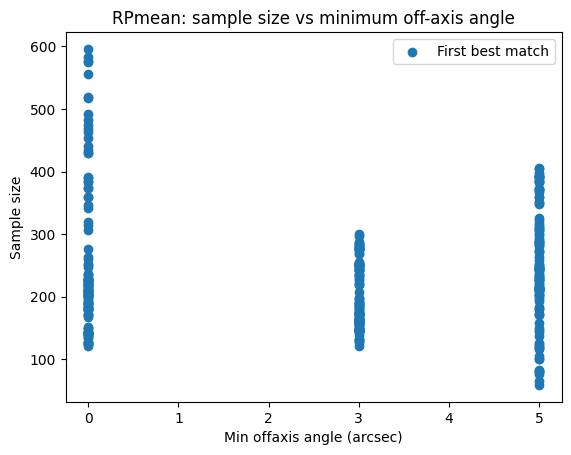

In [155]:
# plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('RPmean: sample size vs separation bin median')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_separation_rpmean.png')
plt.show()

# plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('RPmean: sample size vs minimum off-axis angle')
plt.legend()
plt.savefig('/Users/joshuaingram/Main/Projects/starsml/figures/sample_size_min_offaxis_rpmean.png')
plt.show()